# STAT186: Arizona weather causal effect estimation

In [134]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

In [2]:
os.listdir('../data/')

['.DS_Store',
 'crime_cat.csv',
 'stat186-projdata-2.csv',
 'states-codes-capitals.csv',
 'states-codes-supcourt-city.csv',
 'weather']

In [399]:
data = pd.read_csv('../data/stat186-projdata-2.csv', index_col = 0, low_memory=False)

In [4]:
data.shape

(171409, 341)

In [5]:
data.head(2)

,masterid,id_1,coder,coderid,casen_1,juris,first_ct,agency,agency_r,arbitrat,...,brthyr,race,gender,pajid,jpid,agedec,EWI,select,retentn,cj
0,95.010009765625,102,TEB,1130,1.0,2.0,1.0,0.0,88.0,0.0,...,1929.0,1.0,1.0,47.23,1.0,66.0,-1.454818,5.0,5.0,0.0
1,95.01001739501953,103,TEB,1130,2.0,2.0,2.0,0.0,88.0,0.0,...,1930.0,1.0,1.0,26.20,1.0,65.0,-1.454818,5.0,5.0,0.0


In [400]:
data[['decs_day', 'decs_mo', 'decs_yr']] = data[['decs_day', 'decs_mo', 'decs_yr']].fillna(0)

In [401]:
data['date'] = data['decs_day'].astype(int).astype(str) + '/' + data['decs_mo'].astype(int).astype(str) + '/' + data['decs_yr'].astype(int).astype(str)

In [402]:
data['date'] = pd.to_datetime(data['date'], format = '%d/%m/%Y', errors = 'coerce')

In [403]:
data.drop(['decs_day', 'decs_mo', 'decs_yr'], axis = 1, inplace = True)

In [10]:
judge_vars=['judgecode', 'brthyr','race', 'gender','pajid','jpid', 'agedec', 'EWI', 'select', 'retentn', 'cj']

## Judge data

In [11]:
jdata = data[judge_vars].groupby('judgecode').first()

In [20]:
jdata.agg({'race': 'sum', 'agedec': 'mean', 'gender': 'mean'})

race      517.000000
gender      1.193617
agedec     58.530837
dtype: float64

In [13]:
jdata.groupby('jpid').size()

jpid
1.0    233
2.0    159
3.0      6
dtype: int64

## Partisanship

In [83]:
sum(treatment)/len(treatment)

0.8369681039994317

In [84]:
political_opp = data[['masterid', 'jpid']].groupby('masterid').agg(lambda x : len(pd.unique(x['jpid'])) > 1)

In [85]:
dissent = data[['masterid', 'judgeopinion']].replace(1, 2).groupby('masterid').agg(lambda x : len(pd.unique(x['judgeopinion'])) > 1)

In [86]:
outcome = np.array(dissent['judgeopinion']) * 1

In [87]:
treatment = np.array(political_opp['jpid']) *1

In [99]:
sum(outcome * treatment) / sum(treatment) - sum(outcome * (1-treatment)) / sum(1-treatment)

0.1318072618436084

In [164]:
corr = []
dates = []
var = []
for year in [1995, 1996, 1997, 1998]:
    for m in range(1, 13):
        pre_pres = data[(data['date'].dt.month == m) & (data['date'].dt.year == year)]
        d = pre_pres[['masterid', 'judgeopinion']].replace(1, 2).groupby('masterid').agg(lambda x : len(pd.unique(x['judgeopinion'])) > 1)
        p = pre_pres[['masterid', 'jpid']].groupby('masterid').agg(lambda x : len(pd.unique(x['jpid'])) > 1)
        o = np.array(d['judgeopinion']) * 1
        t = np.array(p['jpid']) *1
        date = str(m) + '/' + str(year)
        dm = sum(o * t) / sum(t) - sum(o * (1-t)) / sum(1-t)
        v = np.sum( (o - np.mean(o))**2 * t) / (sum(t)*(sum(t)-1)) + np.sum((o - np.mean(o))**2 * (1-t)) / (sum(1-t)*(sum(1-t)-1))
        corr.append(dm)
        dates.append(date) 
        var.append(v)

In [141]:
#dates = pd.to_datetime(dates)

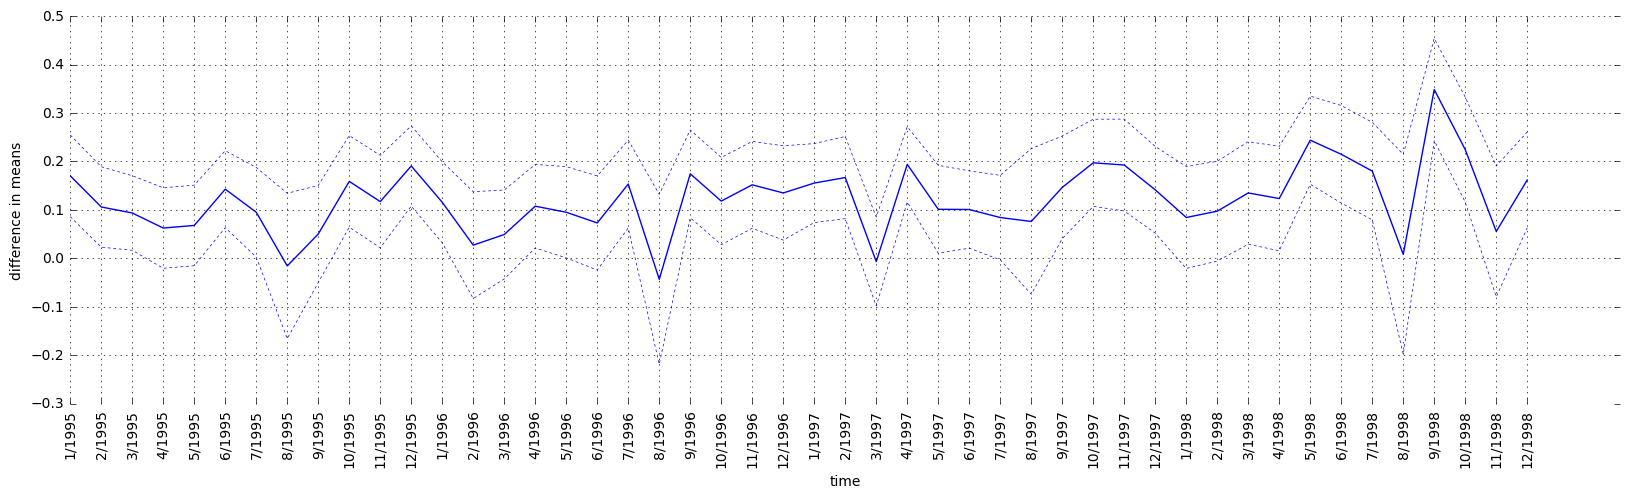

In [163]:
# You typically want your plot to be ~1.33x wider than tall. This plot is a rare    
# exception because of the number of lines being plotted on it.    
# Common sizes: (10, 7.5) and (12, 9)    
plt.figure(figsize=(20, 5))    
  
# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 
ax.plot(corr)
ax.plot(corr + 1.96 * np.sqrt(var), color = 'blue', linewidth = 0.5, dashes=[2, 2])
ax.plot(corr - 1.96 * np.sqrt(var), color = 'blue', linewidth = 0.5, dashes=[2, 2])
ax.set_xticks(np.arange(0, len(dates), step=1))
ax.set_xlabel('time')
ax.set_ylabel('difference in means')
ax.set_xticklabels(dates, rotation=90)
plt.grid(b=None, which='major', axis='both')
plt.show()

## Partisanship by judge

Treatment: having a different political affiliation than the justice who writes the majority opinion.
Outcome: dissenting.

In [341]:
# political opposition with first judge
first_judge = data[data['judgeopinion']==1]

In [342]:
len(first_judge)/len(data['masterid'].unique())

0.8468423669816012

In [343]:
fj = first_judge[['masterid', 'jpid']].set_index('masterid')
fj.columns = ['firstjpid']

In [314]:
data[data['jpid']==1]['pajid'].quantile(q=[0.05, 0.25,0.5,0.75, 0.95])

0.05    21.90
0.25    39.77
0.50    50.17
0.75    62.45
0.95    86.69
Name: pajid, dtype: float64

In [315]:
data[data['jpid']==2]['pajid'].quantile(q=[0.05, 0.25,0.5,0.75, 0.95])

0.05     2.89
0.25    20.20
0.50    23.63
0.75    25.74
0.95    55.33
Name: pajid, dtype: float64

In [305]:
data[data['jpid']==3]['pajid'].mean()

41.76438140806599

In [332]:
fj[fj['jpid'].isna()].tail()

,jpid,judgecode,pajid
masterid,,,
95.41081237792969,NaN,88.0,NaN
95.42015838623047,NaN,88.0,NaN
97.18144226074219,NaN,88.0,NaN
97.27152252197266,NaN,88.0,NaN
98.45092010498047,NaN,88.0,NaN


In [333]:
fj.isna().sum()/len(fj)

jpid         0.147932
judgecode    0.000210
pajid        0.030492
dtype: float64

In [404]:
data2 = pd.merge(data, fj, left_on = 'masterid', right_index = True, how = 'left')

In [396]:
data2.head(2)

,masterid,id_1,coder,coderid,casen_1,juris,first_ct,agency,agency_r,arbitrat,...,race,gender,pajid,jpid,agedec,EWI,select,retentn,cj,firstjpid
0,95.010009765625,102,TEB,1130,1.0,2.0,1.0,0.0,88.0,0.0,...,1.0,1.0,47.23,1.0,66.0,-1.454818,5.0,5.0,0.0,1.0
1,95.01001739501953,103,TEB,1130,2.0,2.0,2.0,0.0,88.0,0.0,...,1.0,1.0,26.20,1.0,65.0,-1.454818,5.0,5.0,0.0,1.0


In [405]:
data2 = data2[data2['judgeopinion'] != 1]
data2['opposition'] = (data2['jpid'] != data2['firstjpid'])
data2['dissent'] = (data2['judgeopinion'] != 1) & (data2['judgeopinion'] != 2)

In [355]:
data2 = data2[['dissent', 'opposition']].dropna(axis = 0)

In [414]:
o = np.array(data2['dissent'])*1
t = np.array(data2['opposition'])*1

In [416]:
def permute(a):
    ind = np.random.permutation(len(a))
    return a[ind]

def diff_means(tr, oc):
    return np.sum(tr * oc)/ np.sum(tr) - np.sum((1-tr) * oc) / np.sum(1-tr)

In [417]:
N = 5000
dm = np.zeros(N)
tdm = diff_means(t, o)
tdm

0.023269098406839606

In [418]:
for i in range(N):
    u = permute(t)
    dm[i] = diff_means(u, o)

In [419]:
sum(dm > tdm)/N

0.0

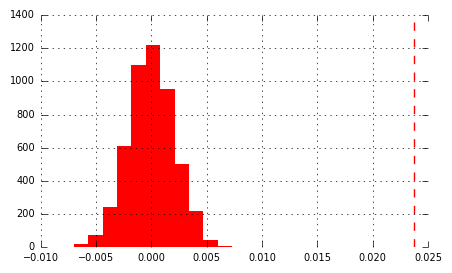

In [391]:
# You typically want your plot to be ~1.33x wider than tall. This plot is a rare    
# exception because of the number of lines being plotted on it.    
# Common sizes: (10, 7.5) and (12, 9)    
plt.figure(figsize=(5, 3))    
  
# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 
ax.hist(dm, color = 'red', linewidth=0, bins = 12)
ax.axvline(tdm, color='red', linestyle='dashed', linewidth=1)
plt.tick_params(labelsize=7)
plt.grid(b=None, which='major', axis='both')

In [435]:
corr = []
dates = []
var = []
for year in [1995, 1996, 1997, 1998]:
    for m in range(1, 13):
        d = data2[(data2['date'].dt.month == m) & (data2['date'].dt.year == year)]
        o = np.array(d['dissent'])*1
        t = np.array(d['opposition'])*1
        date = str(m) + '/' + str(year)
        
        #if sum(t)*(sum(t)-1)*sum(1-t)*(sum(1-t)-1) > 0:
        dm = sum(o * t) / sum(t) - sum(o * (1-t)) / sum(1-t)
        v = np.sum( (o - np.mean(o))**2 * t) / (sum(t)*(sum(t)-1)) + np.sum((o - np.mean(o))**2 * (1-t)) / (sum(1-t)*(sum(1-t)-1))
        corr.append(dm)
        dates.append(date) 
        var.append(v)

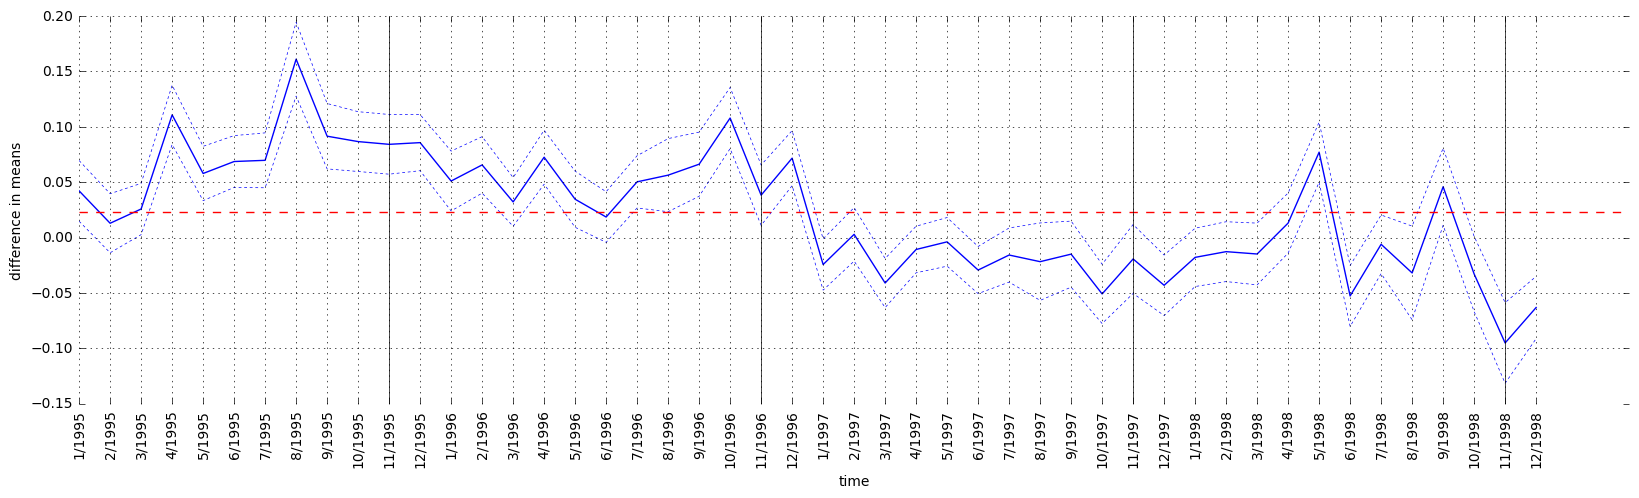

In [440]:
# You typically want your plot to be ~1.33x wider than tall. This plot is a rare    
# exception because of the number of lines being plotted on it.    
# Common sizes: (10, 7.5) and (12, 9)    
plt.figure(figsize=(20, 5))    
  
# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 
ax.plot(corr)
ax.plot(corr + 1.96 * np.sqrt(var), color = 'blue', linewidth = 0.5, dashes=[2, 2])
ax.plot(corr - 1.96 * np.sqrt(var), color = 'blue', linewidth = 0.5, dashes=[2, 2])
ax.set_xticks(np.arange(0, len(dates), step=1))
ax.set_xlabel('time')
ax.set_ylabel('difference in means')
ax.set_xticklabels(dates, rotation=90)
ax.axhline(tdm, color='red', linestyle='dashed', linewidth=1)
ax.axvline(10, color='k', linewidth=0.5)
ax.axvline(22, color='k', linewidth=0.5)
ax.axvline(34, color='k', linewidth=0.5)
ax.axvline(46, color='k', linewidth=0.5)
plt.grid(b=None, which='major', axis='both')
plt.show()

$\textrm{logit}(p_{ij}) = X_{case}$